In [24]:
import os, json, joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

DATA = "../data/processed/phase5_dataset.parquet"
MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

TARGET = "energy_kwh"
KEYS   = ["ZoneID","date"]


In [25]:
df = pd.read_parquet(DATA).copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ZoneID","date"]).reset_index(drop=True)

# Drop rows with missing TARGET
df = df.dropna(subset=[TARGET]).copy()

print(df.shape, df["date"].min(), "→", df["date"].max())
df.head(3)


(212073, 23) 2023-01-02 00:00:00 → 2025-08-09 00:00:00


,ZoneID,date,energy_kwh,year,month,doy,dow,is_weekend,roll7_mean,roll7_std,...,anom_month_kwh,y_lag1,y_lag7,y_lag14,y_mean_7d,y_std_7d,y_min_7d,y_max_7d,sin_doy,cos_doy
0,BLR-0001,2023-01-02,57.866284,2023,1,2,0,False,NaN,NaN,...,7.050867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034398,0.999408
1,BLR-0001,2023-01-03,53.828780,2023,1,3,1,False,NaN,NaN,...,3.013362,57.866284,NaN,NaN,NaN,NaN,NaN,NaN,0.051584,0.998669
2,BLR-0001,2023-01-04,54.480626,2023,1,4,2,False,55.391897,1.769778,...,3.665208,53.828780,NaN,NaN,NaN,NaN,NaN,NaN,0.068755,0.997634


In [26]:
# Everything numeric except keys + target
non_feats = set(KEYS + [TARGET])
ALL_NUM_FEATS = [c for c in df.columns if c not in non_feats and pd.api.types.is_numeric_dtype(df[c])]

nan_counts = df[ALL_NUM_FEATS].isna().sum().sort_values(ascending=False)
print("n_features:", len(ALL_NUM_FEATS))
print("Top features with NaNs:")
display(nan_counts.head(10))


n_features: 20
Top features with NaNs:


roll7_z        14941
y_lag14         3122
roll30_mean     2007
y_lag7          1561
y_max_7d         669
y_min_7d         669
y_std_7d         669
y_mean_7d        669
roll7_mean       446
roll7_std        446
dtype: int64

In [27]:
# Use a test window with real production (avoid the all-zero June)
train = df[df["date"] < "2025-04-01"].copy()
test  = df[(df["date"] >= "2025-04-01") & (df["date"] < "2025-06-01")].copy()

X_train_full = train.drop(columns=[TARGET, "date"])
X_test_full  = test.drop(columns=[TARGET, "date"])
y_train = train[TARGET].to_numpy()
y_test  = test[TARGET].to_numpy()

print("Train:", train["date"].min(), "→", train["date"].max(), "n=", len(train))
print("Test :", test["date"].min(), "→", test["date"].max(), "n=", len(test))


Train: 2023-01-02 00:00:00 → 2025-03-31 00:00:00 n= 182860
Test : 2025-04-01 00:00:00 → 2025-05-31 00:00:00 n= 13603


In [28]:
# Columns that can cause leakage-like behavior (direct lags of target)
LEAK_FEATURES = ["y_yesterday", "y_lag1", "y_lag7", "y_lag14"]

all_feats = [c for c in X_train_full.columns if c != "ZoneID"]  # exclude ZoneID here (we won't one-hot for ridge in this cleaned baseline)
ridge_feats = [f for f in all_feats if f not in LEAK_FEATURES]   # remove lags from Ridge
xgb_feats   = all_feats                                         # keep everything for XGB

print("Ridge features (#={}):".format(len(ridge_feats)))
print(sorted(ridge_feats)[:10], "...")
print("XGB features   (#={}):".format(len(xgb_feats)))
print(sorted(xgb_feats)[:10], "...")


Ridge features (#=17):
['anom_month_kwh', 'clim_month_kwh', 'cos_doy', 'dow', 'doy', 'is_weekend', 'month', 'roll30_mean', 'roll7_mean', 'roll7_std'] ...
XGB features   (#=20):
['anom_month_kwh', 'clim_month_kwh', 'cos_doy', 'dow', 'doy', 'is_weekend', 'month', 'roll30_mean', 'roll7_mean', 'roll7_std'] ...


In [29]:
# RIDGE: impute -> scale -> ridge
ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("mdl", Ridge(alpha=1.0, random_state=42))
])

# XGB: (imputer for safety) -> xgb
xgb = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("mdl", XGBRegressor(
        n_estimators=700,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=4,
        tree_method="hist"
    ))
])


In [31]:
ridge.fit(X_train_full[ridge_feats], y_train)
xgb.fit(X_train_full[xgb_feats], y_train)
print("trained ridge (baseline) & xgb (main)")


trained ridge (baseline) & xgb (main)


In [32]:
def safe_mape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

y0_rate = float(np.mean(np.isclose(y_test, 0.0))) * 100.0
print(f"[Test target] zero (or ~zero) proportion: {y0_rate:.2f}%")

def eval_model(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    r    = rmse(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    nz   = ~np.isclose(y_true, 0.0)
    mape_nz = safe_mape(y_true[nz], y_pred[nz]) if nz.any() else float("nan")
    print(f"{name:5s} MAE: {mae:.3f}  MAPE: {mape:.2f}%  MAPE(nz): {mape_nz:.2f}%  RMSE: {r:.3f}")

ridge_pred = ridge.predict(X_test_full[ridge_feats])
xgb_pred   = xgb.predict(X_test_full[xgb_feats])

eval_model("RIDGE", y_test, ridge_pred)
eval_model("XGB",   y_test, xgb_pred)


[Test target] zero (or ~zero) proportion: 1.64%
RIDGE MAE: 0.000  MAPE: 2498.79%  MAPE(nz): 0.00%  RMSE: 0.000
XGB   MAE: 0.774  MAPE: 26991317.19%  MAPE(nz): 1.13%  RMSE: 2.216


In [34]:
# Save models
joblib.dump(ridge, f"{MODELS_DIR}/solar_ridge.joblib")
joblib.dump(xgb,   f"{MODELS_DIR}/solar_xgb.joblib")

# Save per-model feature lists
with open(f"{MODELS_DIR}/feature_list_ridge.json","w") as f:
    json.dump(ridge_feats, f, indent=2)
with open(f"{MODELS_DIR}/feature_list_xgb.json","w") as f:
    json.dump(xgb_feats, f, indent=2)

# Also write a "default" feature_list.json for downstream code (use XGB by default)
with open(f"{MODELS_DIR}/feature_list.json","w") as f:
    json.dump(xgb_feats, f, indent=2)

meta = {
    "target": TARGET,
    "train_range": [str(train["date"].min().date()), str(train["date"].max().date())],
    "test_range":  [str(test["date"].min().date()),  str(test["date"].max().date())],
    "models": {
        "ridge": {
            "path": "solar_ridge.joblib",
            "feature_list": "feature_list_ridge.json",
            "notes": "baseline, no direct lags"
        },
        "xgb": {
            "path": "solar_xgb.joblib",
            "feature_list": "feature_list_xgb.json",
            "notes": "main model, uses lags"
        }
    },
    "version": 1
}
with open(f"{MODELS_DIR}/meta.json","w") as f:
    json.dump(meta, f, indent=2)

print("saved models & metadata to", MODELS_DIR)


saved models & metadata to ../models


Using features: ['year', 'month', 'doy', 'dow', 'is_weekend', 'roll7_mean', 'roll7_std', 'roll7_z', 'roll30_mean', 'clim_month_kwh', 'anom_month_kwh', 'y_lag1', 'y_lag7', 'y_lag14', 'y_mean_7d', 'y_std_7d', 'y_min_7d', 'y_max_7d', 'sin_doy', 'cos_doy']


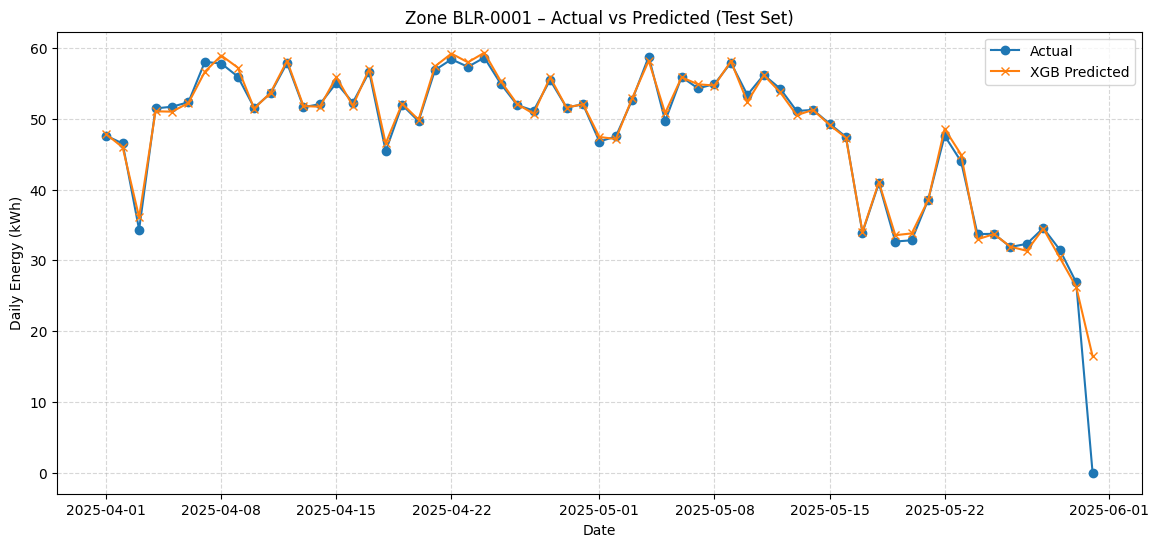

In [39]:
# Cell: visualize predictions for one zone

zone = "BLR-0001"

# Ensure test_df is reconstructed
test_df = df[(df["date"] >= "2025-04-01") & (df["date"] <= "2025-05-31")].copy()

zone_test = test_df[test_df["ZoneID"] == zone].copy()
zone_test = zone_test.sort_values("date")

# Pull exact features from model training
try:
    XGB_FEATS = xgb.feature_names_in_.tolist()
except AttributeError:
    # If it's a pipeline with preprocessor
    XGB_FEATS = xgb.named_steps['preprocessor'].get_feature_names_out().tolist()

print("Using features:", XGB_FEATS)

# Predict
zone_test["y_pred"] = xgb.predict(zone_test[XGB_FEATS])

# Plot
plt.figure(figsize=(14,6))
plt.plot(zone_test["date"], zone_test["energy_kwh"], label="Actual", marker="o")
plt.plot(zone_test["date"], zone_test["y_pred"], label="XGB Predicted", marker="x")
plt.title(f"Zone {zone} – Actual vs Predicted (Test Set)")
plt.xlabel("Date")
plt.ylabel("Daily Energy (kWh)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()




